##Brain Tumor classification


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset #downloads the brain tumor MRI dataset using the Kaggle API.


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
import zipfile

with zipfile.ZipFile("brain-tumor-mri-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("brain_tumor_data")


This code downloads and prepares the brain tumor MRI dataset for analysis. First, it sets up access to the Kaggle API to download the data. Next, it downloads the actual dataset and extracts it into a usable format.

### Import libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


let's define the paths to the training and testing data directories.

In [ ]:
train="/content/brain_tumor_data/Training"
test="/content/brain_tumor_data/Testing"

In [ ]:

classes=os.listdir(train) #Gives the list of classes (types of brain tumors) from the training directory.
classes

['pituitary', 'glioma', 'notumor', 'meningioma']

Now, let's visualize these classes.

In [ ]:
def count_per_classes(dir):
  count_classes={}
  for classes in os.listdir(dir):
    count_classes[classes]=len(os.listdir(os.path.join(dir,classes)))
  return count_classes

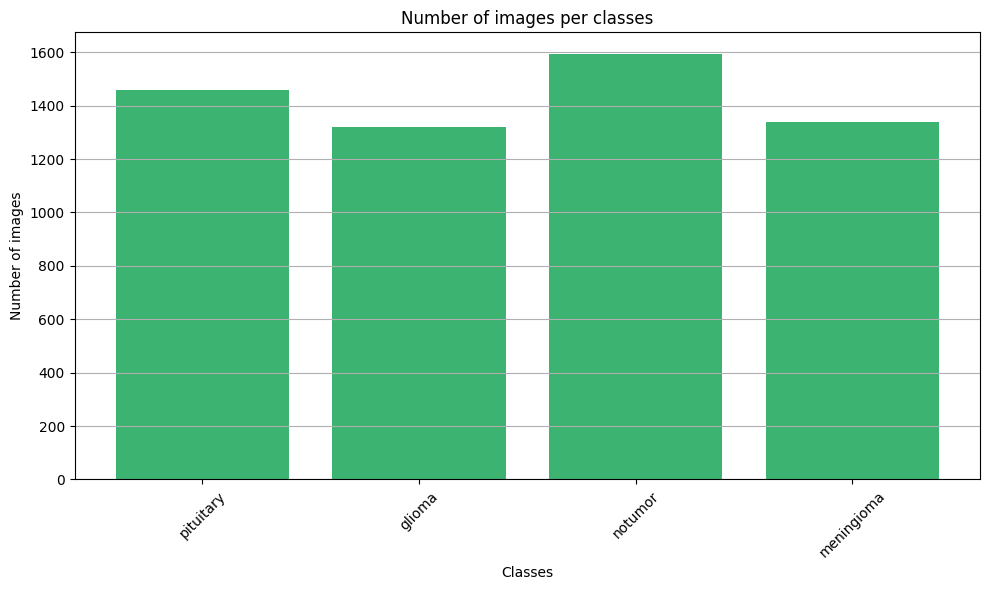

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(x=list(count_per_classes(train).keys()),height=list(count_per_classes(train).values()),color='mediumseagreen')
plt.title("Number of images per classes")
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As you can see, the dataset has limited diversity in MRI scans, which may lead to overfitting. So, we apply **`data augmentation`** to introduce variations and help the model generalize better to unseen data.

In [ ]:
# Data augmentation and preprocessing for training images
datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to the range [0, 1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    zoom_range=0.2,             # Randomly zoom in on images by up to 15%
    shear_range=0.2,            # Shear the image by up to 15% (diagonal distortion)
    horizontal_flip=True,        # Randomly flip images horizontally (mirror image)
    fill_mode="nearest",         # Fill in newly created pixels after rotation/shift using the nearest pixel value
    validation_split=0.2         # Reserve 20% of data for validation (splits internally)
)

We use **`ImageDataGenerator`** to apply both data augmentation and preprocessing to the training images. The training images are rescaled to the range
[0,1], and augmentations like rotation, zoom, and horizontal flip are applied to introduce variability and improve generalization.

Using the `validation_split parameter`, we automatically split 20% of the training data for validation. Two separate generators are created:

`train_generator`: Loads 80% of the training data with augmentation applied.

`val_generator`: Loads 20% of the data for validation, with only rescaling (no augmentation).

## split the data

In [ ]:
#Training Data
train_generator = datagen.flow_from_directory(
    train,
    target_size=(224,224),     # Resize all images to 64x64 pixels
    batch_size=32,            # Load images in batches of 32
    class_mode='categorical', # Use one-hot encoding for multi-class classification
    subset='training',        # Load the training subset (from validation_split)
    shuffle=True
)


#validation data
val_generator = datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Load the validation
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
list(train_generator.class_indices.keys())

['glioma', 'meningioma', 'notumor', 'pituitary']

Now let's visualize a few sample images from the training set along with their corresponding labels.

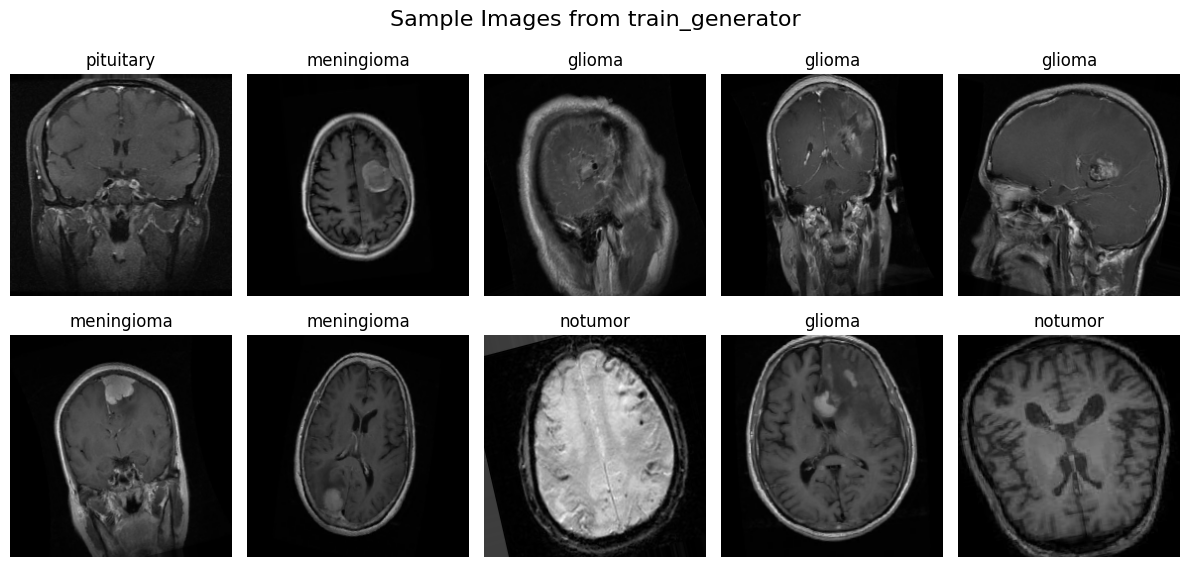

In [ ]:
images,labels=next(train_generator)

classes=list(train_generator.class_indices.keys())
classes

plt.figure(figsize=(12,6))
for i in range(10):
  ax=plt.subplot(2,5,i+1)
  plt.imshow(images[i])
  class_names=np.argmax(labels[i])
  plt.title(classes[class_names])
  plt.axis("off")

plt.suptitle("Sample Images from train_generator", fontsize=16)
plt.tight_layout()
plt.show()


## Custom CNN Model Building

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,258,948 (54.39 MB)

 Trainable params: 14,258,948 (54.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Specify batch size and no of epochs
batch_size = 32 #(optinal as we already specified in geneator)
epochs = 20

In [ ]:
early_stoping = EarlyStopping(monitor='val_accuracy', patience=4)

### Train the model

In [ ]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 568ms/step - accuracy: 0.4519 - loss: 1.1035 - val_accuracy: 0.6933 - val_loss: 0.8517
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.7379 - loss: 0.6472 - val_accuracy: 0.6976 - val_loss: 0.8004
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.7730 - loss: 0.5518 - val_accuracy: 0.7204 - val_loss: 0.7661
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.8034 - loss: 0.4760 - val_accuracy: 0.7493 - val_loss: 0.6807
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 476ms/step - accuracy: 0.8405 - loss: 0.3983 - val_accuracy: 0.7660 - val_loss: 0.6970
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 493ms/step - accuracy: 0.8542 - loss: 0.3705 - val_accuracy: 0.7669 - val_loss: 0.6758
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.8890 - loss: 0.2998 - val_accuracy: 0.7984 - val_loss: 0.6418
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 498ms/step - accuracy: 0.9024 - loss: 0

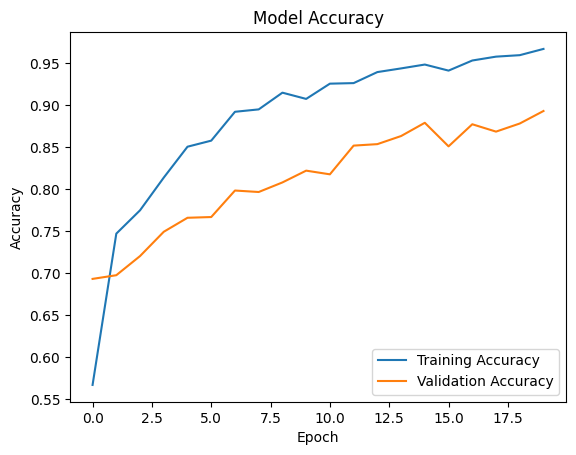

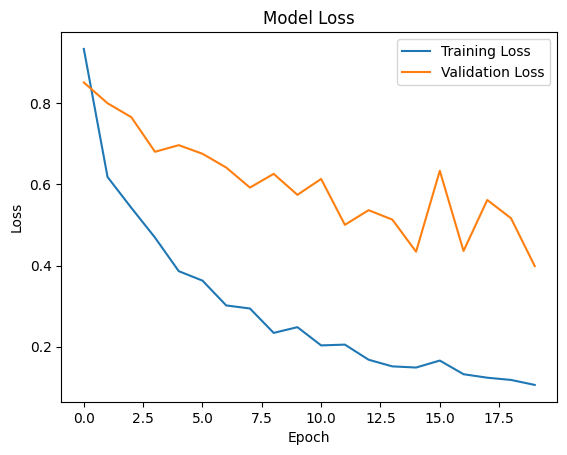

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history["accuracy"],label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.show()



#plot training and validation loss values

plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()

Our custom CNN model has achieved a training accuracy of 96% and a validation accuracy of 89%. While these results are promising, the slight gap between training and validation performance suggests a degree of overfitting.

### Save the custom CNN model

In [ ]:
model.save('my_model.h5')

In [ ]:
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')

### Preprocessing

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)

### Importing the test data using test_generator

In [ ]:
# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    test,  # Replace with your test directory path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for keeping the order of predictions
)

Found 1311 images belonging to 4 classes.


In [ ]:
1# Generate predictions
predictions = model.predict(test_generator)

# If using categorical classification, get the class indices
import numpy as np
predicted_classes = np.argmax(predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8690 - loss: 0.3466
Test Accuracy: 0.9199
Test Loss: 0.2276


In [ ]:
# True labels
true_classes = test_generator.classes

# Class label indices to class name mapping
class_labels = list(test_generator.class_indices.keys())

### Model Evalution

In [ ]:
# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Precision
precision = precision_score(true_classes, predicted_classes, average='weighted')

# Recall
recall = recall_score(true_classes, predicted_classes, average='weighted')

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


Accuracy: 0.9199
Precision (weighted): 0.9211
Recall (weighted): 0.9199
F1 Score (weighted): 0.9184


Our custom CNN model achieved a test accuracy of 91.99%, demonstrating strong overall performance. With a weighted precision of 92.11% and recall of 91.99%, the model effectively captures relevant instances across all classes. The weighted F1 score of 91.84% indicates a balanced trade-off between precision and recall, highlighting its reliability in brain tumor classification.

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


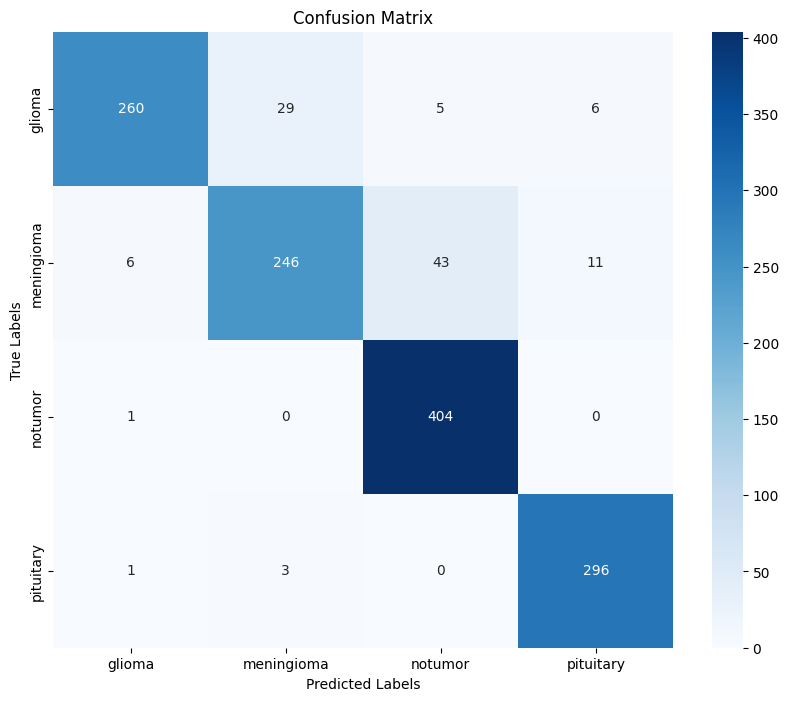

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Our custom CNN model shows strong performance in classifying 'no_tumor' images, with almost all instances correctly classified. However, there's a noticeable confusion between 'glioma' and 'meningioma', indicating that these two classes share some visual characteristics that the model struggles to differentiate.


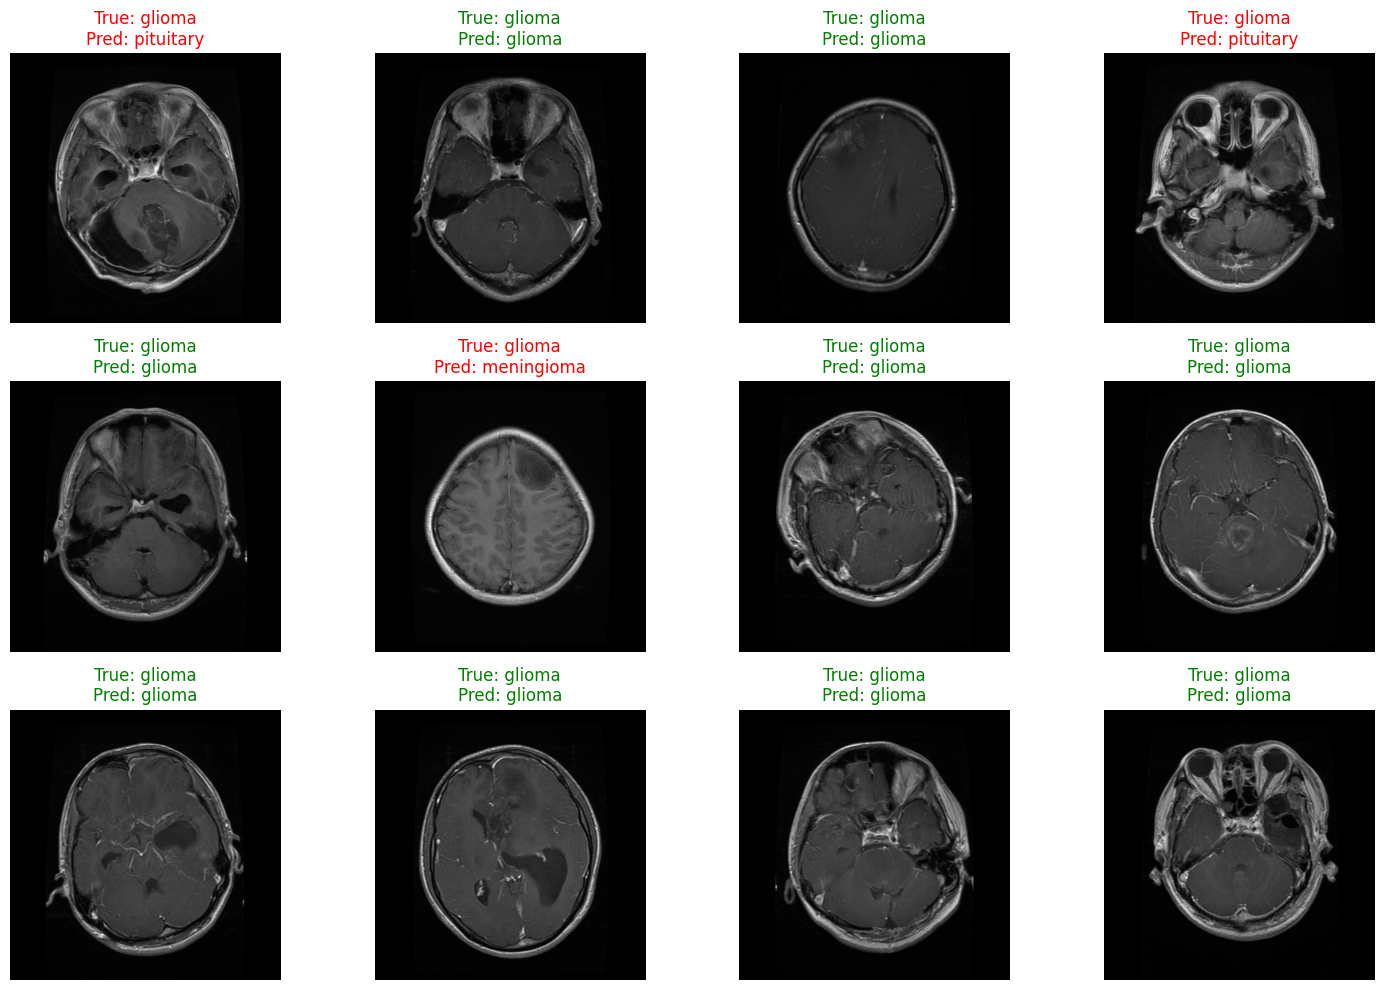

In [ ]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 12

# Get image file paths
image_paths = test_generator.filepaths

# Plot images with labels
plt.figure(figsize=(15, 10))
for i in range(num_images):
    # Load and display image
    img = plt.imread(image_paths[i])
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Set title with true and predicted labels
    true_label = class_labels[true_classes[i]]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f'True: {true_label}\nPred: {predicted_label}', color='green' if true_label == predicted_label else 'red')

plt.tight_layout()
plt.show()


These are the predicitons made by our custom CNN model.

---
### Transfer Learning
---

Transfer learning is used in this brain tumor classification project to leverage the powerful feature extraction capabilities of pre-trained deep learning models like VGG16.

In [ ]:
from keras.applications import VGG16

In [ ]:
# Load VGG16 without the top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
vgg_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Here, we're freezing the convolution base.By freezing the convolutional base of VGG16 and training only the fully connected layers (or fine-tuning the last few convolutional blocks), the model can quickly adapt to the specific task of classifying MRI brain scans into categories like glioma, meningioma, pituitary, and no tumor.

In [ ]:
vgg_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Now let's create the fully connected layers.

In [ ]:
from tensorflow.keras import layers

vgg_model=Sequential()
vgg_model.add(vgg_base)
vgg_model.add(layers.Flatten())
vgg_model.add(Dense(512, activation='relu')) #
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dense(64, activation='relu'))
vgg_model.add(layers.Dense(4, activation='softmax'))  # Adjust the number of classes


In [ ]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,732,996 (105.79 MB)

 Trainable params: 13,018,308 (49.66 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

After adding the fully connected layer.we have 27.7 million total parameters,Out of which 13 million are trainable, and 14.7 million are non-trainable.

In [ ]:
vgg_history=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 112s 685ms/step - accuracy: 0.6232 - loss: 1.0369 - val_accuracy: 0.7038 - val_loss: 0.7765
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 543ms/step - accuracy: 0.8701 - loss: 0.3447 - val_accuracy: 0.7748 - val_loss: 0.6339
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 546ms/step - accuracy: 0.8918 - loss: 0.2822 - val_accuracy: 0.7975 - val_loss: 0.6993
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 534ms/step - accuracy: 0.8837 - loss: 0.3059 - val_accuracy: 0.8475 - val_loss: 0.4813
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 540ms/step - accuracy: 0.9362 - loss: 0.1939 - val_accuracy: 0.8580 - val_loss: 0.4171
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.9262 - loss: 0.1865 - val_accuracy: 0.8501 - val_loss: 0.4379
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 535ms/step - accuracy: 0.9246 - loss: 0.1950 - val_accuracy: 0.8685 - val_loss: 0.3840
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 529ms/step - accuracy: 0.9286 - loss: 

The transfer learning model showed strong performance, starting at 62% and reaching 87.6% validation accuracy by epoch 20. It outperformed the custom CNN early on, indicating effective feature reuse and faster convergence.

### Evaluation of the VGG16 Model on Test Data

In [ ]:
# Evaluate the fine-tuned model on the test set
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(test_generator)
print(f'Test Accuracy (Fine-Tuned): {vgg_test_accuracy:.4f}')
print(f'Test Loss (Fine-Tuned): {vgg_test_loss:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 432ms/step - accuracy: 0.8857 - loss: 0.3927
Test Accuracy (Fine-Tuned): 0.9184
Test Loss (Fine-Tuned): 0.2964


In [ ]:
1# Generate predictions
vgg_predictions = vgg_model.predict(test_generator)

# If using categorical classification, get the class indices
import numpy as np
vgg_predicted_classes = np.argmax(vgg_predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step


In [ ]:
# Accuracy
vgg_accuracy = accuracy_score(true_classes, vgg_predicted_classes)

# Precision
vgg_precision = precision_score(true_classes, vgg_predicted_classes, average='weighted')

# Recall
vgg_recall = recall_score(true_classes, vgg_predicted_classes, average='weighted')

# F1 Score
vgg_f1 = f1_score(true_classes, vgg_predicted_classes, average='weighted')

# Display the metrics
print(f"Accuracy: {vgg_accuracy:.4f}")
print(f"Precision (weighted): {vgg_precision:.4f}")
print(f"Recall (weighted): {vgg_recall:.4f}")
print(f"F1 Score (weighted): {vgg_f1:.4f}")


Accuracy: 0.9184
Precision (weighted): 0.9221
Recall (weighted): 0.9184
F1 Score (weighted): 0.9168


The VGG16 model gave almost the same test results as our custom CNN model

In [ ]:
# Compute confusion matrix
cm_vgg = confusion_matrix(true_classes, vgg_predicted_classes)


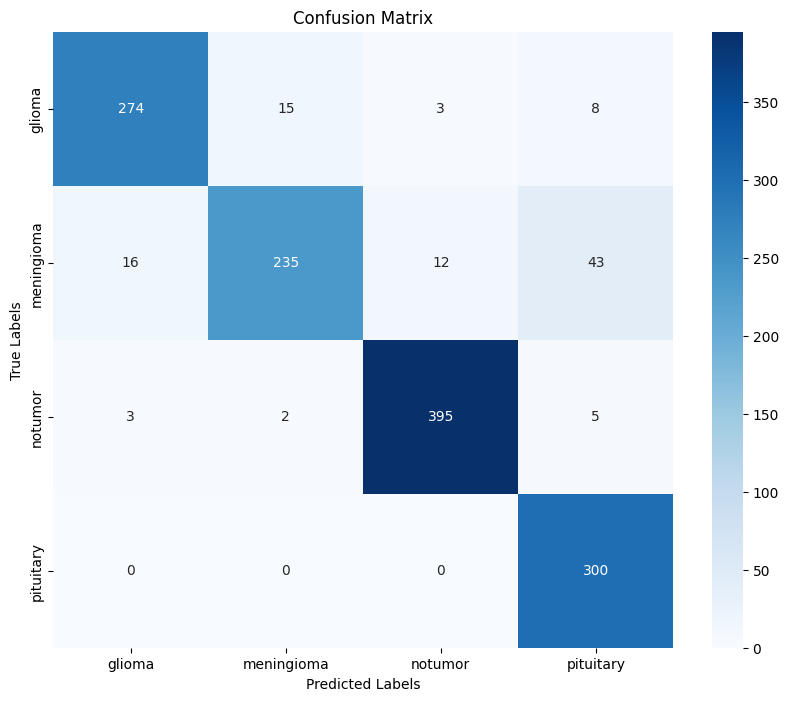

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Transfer learning model demonstrates strong performance in classifying 'no_tumor' images.  It shows some confusion between 'glioma' and 'meningioma', suggesting these categories share visual similarities.  Overall accuracy is high, but the misclassifications between these two tumor types indicate a potential area for improvement in model training or feature engineering.  The model generally performs well across all categories.


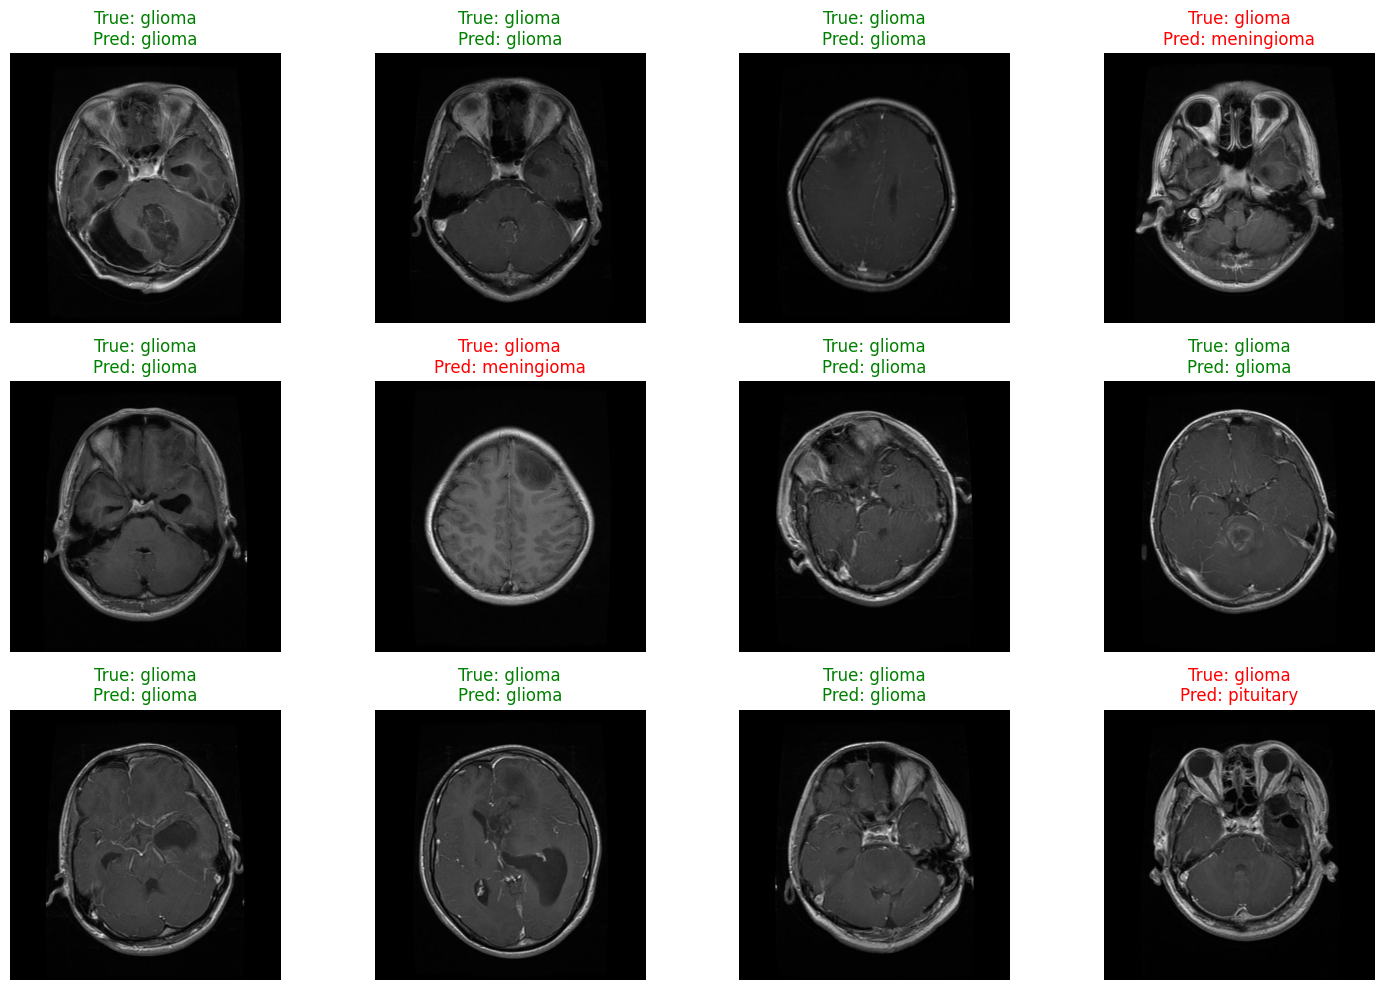

In [ ]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 12

# Get image file paths
image_paths = test_generator.filepaths

# Plot images with labels
plt.figure(figsize=(15, 10))
for i in range(num_images):
    # Load and display image
    img = plt.imread(image_paths[i])
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Set title with true and predicted labels
    true_label = class_labels[true_classes[i]]
    vgg_predicted_label = class_labels[vgg_predicted_classes[i]]
    plt.title(f'True: {true_label}\nPred: {vgg_predicted_label}', color='green' if true_label == vgg_predicted_label else 'red')

plt.tight_layout()
plt.show()


---
## Fine-Tunning the VGG16 model
---

- We fine-tune VGG16 by unfreezing the top layers to allow the model to adapt its high-level features to our specific dataset.                   
- While the earlier layers capture general features like edges and textures, the deeper layers learn task-specific patterns.                  
- By making the top layers trainable, we enable the model to better capture domain-specific details, improving accuracy and generalization.

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 145s 798ms/step - accuracy: 0.9643 - loss: 0.1076 - val_accuracy: 0.8755 - val_loss: 0.4159
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 631ms/step - accuracy: 0.9621 - loss: 0.1001 - val_accuracy: 0.8992 - val_loss: 0.3491
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 630ms/step - accuracy: 0.9851 - loss: 0.0482 - val_accuracy: 0.8861 - val_loss: 0.4155
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 666ms/step - accuracy: 0.9843 - loss: 0.0461 - val_accuracy: 0.8966 - val_loss: 0.4518
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 614ms/step - accuracy: 0.9773 - loss: 0.0669 - val_accuracy: 0.8861 - val_loss: 0.4817
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 621ms/step - accuracy: 0.9773 - loss: 0.0611 - val_accuracy: 0.9202 - val_loss: 0.3195
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - accuracy: 0.9894 - loss: 0.0359 - val_accuracy: 0.8904 - val_loss: 0.4724
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 656ms/step - accuracy: 0.9840 - loss:

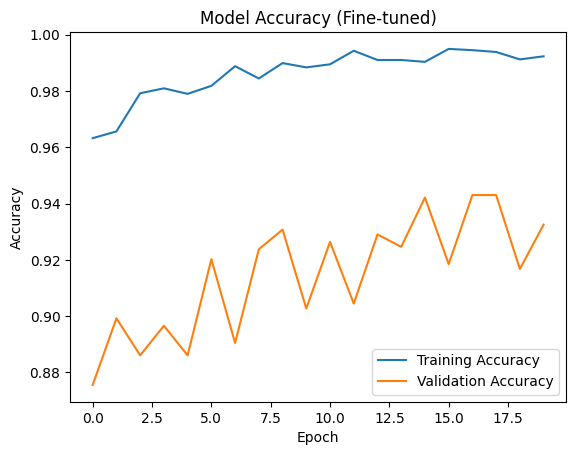

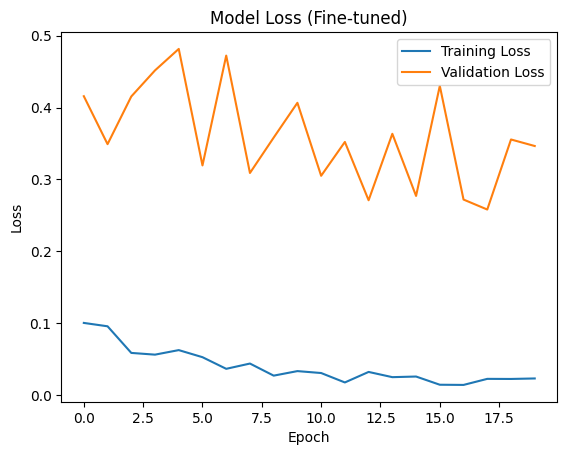

In [ ]:
import matplotlib.pyplot as plt
# Unfreeze some of the top layers of the VGG16 model
for layer in vgg_base.layers[-15:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
vgg_history_finetune = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

# Plot training & validation accuracy values after fine-tuning
plt.plot(vgg_history_finetune.history["accuracy"], label="Training Accuracy")
plt.plot(vgg_history_finetune.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy (Fine-tuned)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.show()

# Plot training and validation loss values after fine-tuning
plt.plot(vgg_history_finetune.history["loss"], label="Training Loss")
plt.plot(vgg_history_finetune.history["val_loss"], label="Validation Loss")
plt.title("Model Loss (Fine-tuned)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()


The fine-tuned VGG16 model demonstrated consistently high training accuracy, reaching over 99% by epoch 12, while validation accuracy peaked at 94.3%, showing strong generalization. Validation loss fluctuated slightly but stayed under control, with the lowest at 0.2581 in epoch 18. This indicates the model effectively learned discriminative features and achieved excellent performance after fine-tuning.

## Evaluate the fine-tuned model on the test dataset

In [ ]:
# Evaluate the fine-tuned model on the testdataset
vgg_ft_test_loss, vgg_ft_test_accuracy = vgg_model.evaluate(test_generator)
print(f'Test Accuracy (Fine-Tuned): {vgg_ft_test_accuracy:.4f}')
print(f'Test Loss (Fine-Tuned): {vgg_ft_test_loss:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9088 - loss: 0.3817
Test Accuracy (Fine-Tuned): 0.9405
Test Loss (Fine-Tuned): 0.2629


In [ ]:
1# Generate predictions
vgg_ft_predictions = vgg_model.predict(test_generator)

# If using categorical classification, get the class indices
import numpy as np
vgg_ft_predicted_classes = np.argmax(vgg_ft_predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step


In [ ]:
# Accuracy
vgg_ft_accuracy = accuracy_score(true_classes, vgg_ft_predicted_classes)

# Precision
vgg_ft_precision = precision_score(true_classes, vgg_ft_predicted_classes, average='weighted')

# Recall
vgg_ft_recall = recall_score(true_classes, vgg_ft_predicted_classes, average='weighted')

# F1 Score
vgg_ft_f1 = f1_score(true_classes, vgg_ft_predicted_classes, average='weighted')

# Display the metrics
print(f"Accuracy: {vgg_ft_accuracy:.4f}")
print(f"Precision (weighted): {vgg_ft_precision:.4f}")
print(f"Recall (weighted): {vgg_ft_recall:.4f}")
print(f"F1 Score (weighted): {vgg_ft_f1:.4f}")


Accuracy: 0.9405
Precision (weighted): 0.9435
Recall (weighted): 0.9405
F1 Score (weighted): 0.9401


The fine-tuned VGG16 model showed improved performance compared to the custom CNN and base VGG16 models, with accuracy increasing to 94.05%. Precision and recall also rose, indicating fewer false positives and better detection of true cases. These gains reflect the benefit of fine-tuning, allowing the model to better adapt to the brain tumor classification task

In [ ]:
# Compute confusion matrix
cm_vgg_ft = confusion_matrix(true_classes, vgg_ft_predicted_classes)


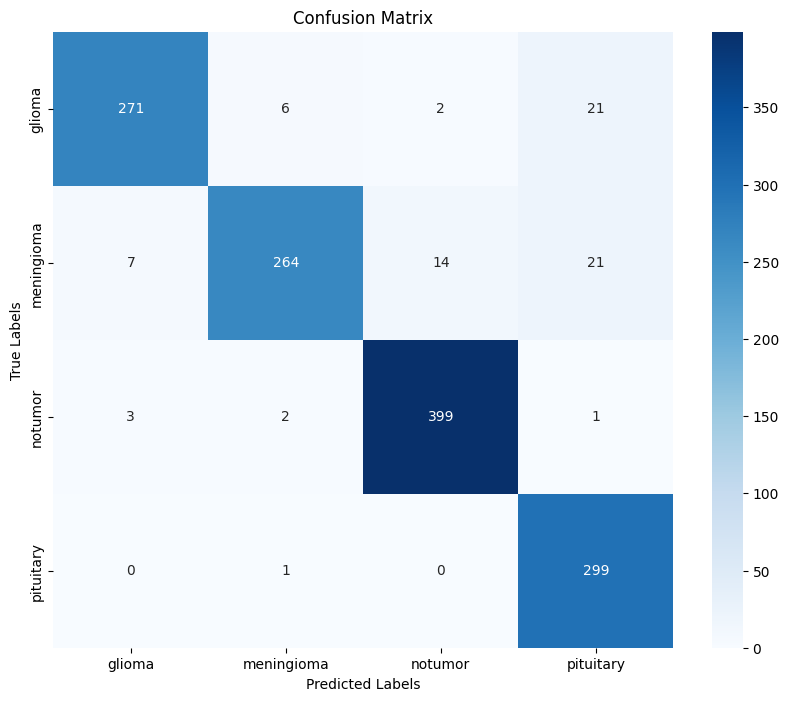

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**Observations**
- The fine-tuned VGG16 model exhibits improved classification, particularly in distinguishing between 'glioma' and 'meningioma', as evidenced by fewer misclassifications in the confusion matrix compared to the previous models.      
- The higher accuracy, precision, recall, and F1-score across all classes demonstrate its superior performance in generalizing to unseen data, surpassing both the custom CNN and the initial VGG16 model.        
- The reduction in misclassifications, especially between visually similar tumor types, highlights the effectiveness of fine-tuning.


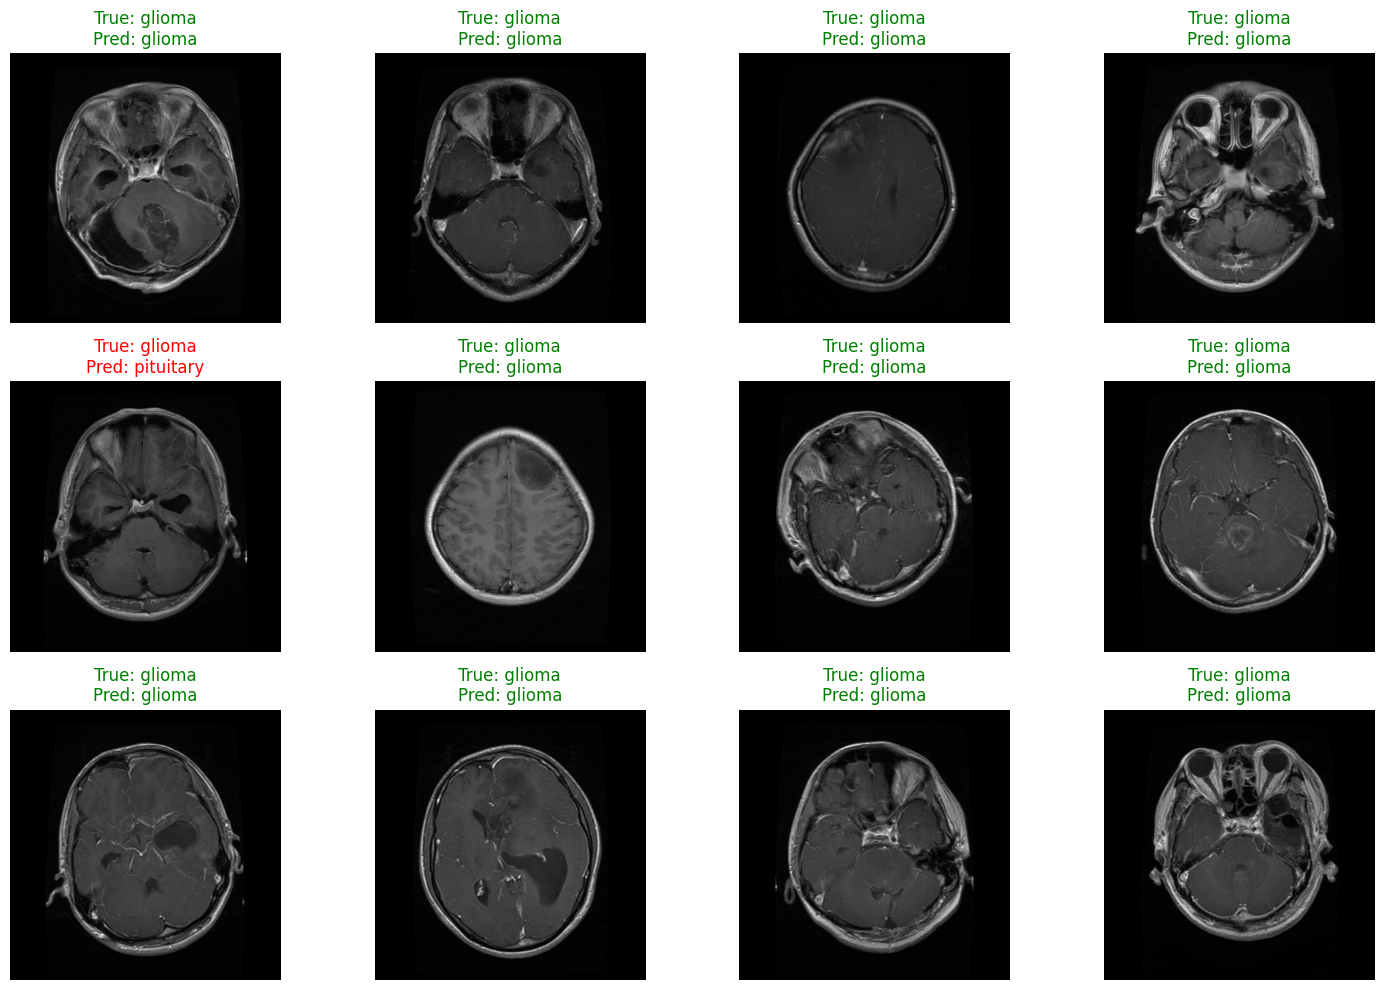

In [ ]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 12

# Get image file paths
image_paths = test_generator.filepaths

# Plot images with labels
plt.figure(figsize=(15, 10))
for i in range(num_images):
    # Load and display image
    img = plt.imread(image_paths[i])
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Set title with true and predicted labels
    true_label = class_labels[true_classes[i]]
    vgg_ft_predicted_label = class_labels[vgg_ft_predicted_classes[i]]
    plt.title(f'True: {true_label}\nPred: {vgg_ft_predicted_label}', color='green' if true_label == vgg_ft_predicted_label else 'red')

plt.tight_layout()
plt.show()


## conclusion

- Developed and evaluated multiple models for brain tumor classification using MRI images.

- Custom CNN model achieved strong performance with ~92% test accuracy.

- Transfer learning using VGG16 produced similar results to the custom CNN.

- Fine-tuned VGG16 showed slight improvements, though gains were marginal.

- Models were evaluated using accuracy, precision, recall, F1-score, and confusion matrices.

- Confusion matrices revealed misclassifications, mainly between visually similar tumor types.

- Transfer learning (especially with fine-tuning) proved to be a robust and efficient approach.

- Custom CNN remains effective, but pre-trained models offer a strong alternative for future work.
